# Linear Model

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In this session we will understand:
- how linear models can be used to predict or interpolate data
- how to fit linear models to data using maximum likelihood and gradient descent
- how to visualize scatterplots, linear models, and histograms
- the basics of pandas, matplotlib, and seaborn
- how to download and open zip files

In [1]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import emcee
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)
pd.set_option('display.max_columns', 70)

# Download & unzip data

Let's download some tennis data so that we can talk about *linear regression*.

Start by downloading the data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.
`urllib.request.urlretrieve` is a function for downloading a file -- similar to `wget`.

Notes:
- don't use `urllib` for writing HTTP client, instead use the wonderful [`requests`](http://python-requests.org) package.
- `os.path.exists` checks for the existence of a file or folder. The [`os.path`](https://docs.python.org/3/library/os.path.html) module has other useful functions, for example, `join` for joining elements of a path. There's also the [`shutil`](https://docs.python.org/3/library/shutil.html) module.

In [2]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/tennis.zip'
filename = '../data/tennis.zip'
if not os.path.exists('../data'):
    os.mkdir('../data')
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

Now open zip file and print its contents.

Note: [`zipfile`](https://docs.python.org/3/library/zipfile.html) is part of Python standard library, which also includes modules for [`gzip`](https://docs.python.org/3/library/gzip.html), [`bz2`](https://docs.python.org/3/library/bz2.html) and other compression formats.

In [3]:
tennis_zip = zipfile.ZipFile(filename)
for f in tennis_zip.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


So we have CSV files for Tennis' [Big Four](https://en.wikipedia.org/wiki/Big_Four_%28tennis%29).

We can open CSV files with the standard library's [`csv`](https://docs.python.org/3/library/csv.html) module, but it is much more convinient to use Pandas.

In [4]:
player = 'Novak Djokovic'
path = 'data/{}.csv'
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,opponent,ranking,score,stats link,tournament.1,tournament round,time,winner,player1 name,player1 nationality,player1 aces,player1 double faults,player1 1st serves in,player1 1st serves total,player1 1st serve points won,player1 1st serve points total,player1 2nd serve points won,player1 2nd serve points total,player1 break points won,player1 break points total,player1 service games played,player1 1st serve return points won,player1 1st serve return points total,player1 2nd serve return points won,player1 2nd serve return points total,player1 break points converted won,player1 break points converted total,player1 return games played,player1 total service points won,player1 total service points total,player1 total return points won,player1 total return points total,player1 total points won,player1 total points total,player2 name,player2 nationality,player2 aces,player2 double faults,player2 1st serves in,player2 1st serves total,player2 1st serve points won,player2 1st serve points total,player2 2nd serve points won,player2 2nd serve points total,player2 break points won,player2 break points total,player2 service games played,player2 1st serve return points won,player2 1st serve return points total,player2 2nd serve return points won,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R32,Gerard Solves (FRA),NaN,"W 6-3, 7-5",http://www.atpworldtour.com/Share/Match-Facts-...,Serbia F6,R32,0,Novak Djokovic,Novak Djokovic,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gerard Solves,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R16,Domenic Marafiote (AUS),566,W 7-6(7) RET,http://www.atpworldtour.com/Share/Match-Facts-...,Serbia F6,R16,0,Novak Djokovic,Novak Djokovic,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domenic Marafiote,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,Q,Ivan Cerovic (CRO),666,"W 6-3, 6-2",http://www.atpworldtour.com/Share/Match-Facts-...,Serbia F6,Q,0,Novak Djokovic,Novak Djokovic,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ivan Cerovic,Croatia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,S,Nicolas Renavand (FRA),785,"L 4-6, 6-7(1)",http://www.atpworldtour.com/Share/Match-Facts-...,Serbia F6,S,0,Nicolas Renavand,Novak Djokovic,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolas Renavand,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,"Serbia F5, Beograd",21.07.2003,FU,Outdoor: Clay,Draw: 32,NaN,774.0,$118,R32,Mohamed Mamoun (EGY),604,"L 7-6(5), 5-7, 0-2 RET",http://www.atpworldtour.com/Share/Match-Facts-...,Serbia F5,R32,0,Mohamed Mamoun,Novak Djokovic,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mohamed Mamoun,Egypt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In a previous session we discussed the correlation between aces and points won, we'll now explore this relationship using a linear model.

We start by plotting the data:

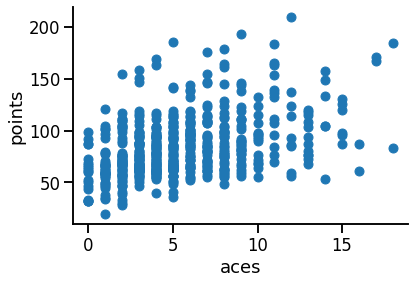

In [5]:
df = df[['player1 aces', 'player1 total points won']]
df = df.dropna()
df = df.sort_values('player1 aces')
x = df['player1 aces'].values
y = df['player1 total points won'].values


plt.plot(x, y, 'o')
plt.xlabel('aces')
plt.ylabel('points')
sns.despine()

# Linear model

Can the number of aces by Novak provide a good predictor of the number of points he won?

The simplest model for such predictions is the linear model
$$
\widehat{y} = ax + b
$$
where here $x$ is the aces and $y$ is the points won.
The model parameters can be interpreted as follows:
- the intercept $b$ is the estimate for points won if 0 points were aced, and
- the slope $a$ is the estimate for the linear increase in points won for every additional ace.

A reasonable null model will have $a=1$ (according to the rules of tennis) and $b=min(y)$ (for the amount of points won without any aces).

We can then calculate the expected outcome $\widehat{y}$ and the residuals $\widehat{y}-y$ which are the differences between the expectations and the observations.

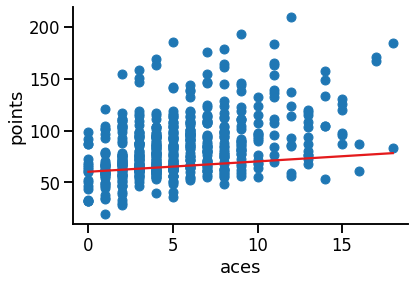

In [6]:
a = 1
b = y[x==0].mean()

yhat = a * x + b

plt.plot(x, y, 'o')
plt.plot(x, yhat, color=red)
plt.xlabel('aces')
plt.ylabel('points')
sns.despine();

For this null model we see that most of the markers are above the lines, which means that our model linear eastimator $\widehat{y}$ is lower than the observed $y$, that is, it is an under-estimation.

How do we proceed to find suitable model parameters $a$ and $b$?

# Maximum likelihood & least squares

In the simplest form of linear modeling, we assume that the data has a normal (or Gaussian) distribution around the linear estimator.
However, this assumption is not a must, and the framework of _generalized linear models_ allow us to replace the normal distribution with other distributions, as descirbed below.
We'll talk about it again later.

Usually, when we speak about probabilities, we ask **"what is the probability to see this data given this model"** - when I say "model" I mean something like 
$$
\widehat{y}=ax+b
$$
with given values for $a$ and $b$, such as $a=1$ and $b=0$, and a normal distribution of observed values around the expected value,
$$
y \sim Normal(\widehat{y}, \sigma^2)
$$
where $\sigma^2$ is the variance of the distribution.

That is, we want to say something about how the observed data is expected to be dispersed given a specific model.

For example, given this model ($a=1, b=0 \Rightarrow y=x$), if $x=1$ then the probability for $y=2$ is:
$$
f(2) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(2-1)^2}{2\sigma^2}\bigg),
$$
and in general, the probability for an observed value $y$ is
$$
f(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(y-\widehat{y})^2}{2\sigma^2}\bigg).
$$

Now, we are ready to find $a$ and $b$, and this is where *likelihood* comes into place, and its definition is straight-forward:

**The likelihood of the model 
$$
y \sim Normal(\widehat{y}=ax+b, \sigma^2)
$$
given observed data $\{(x_i, y_i)\}_i$ is the probability of seeing data given the model.**

If we have mutliple data points (we do!) we can just multiply all of them under the assumption that each data point (here, game, so... not sure that we can do this) is *independent* (in the probability sense of independence, that is, knowing what happened in one of them doesn't change the probability of the other one occuring).

So the likelihood of the model $y \sim Normal(\widehat{y}=ax+b, \sigma^2)$ given data points $\{(x_i, y_i)\}_i$, is

$$
\mathcal{L}(a,b | \{(x_i, y_i)\}) = (2 \pi \sigma^2)^{-n/2} \prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i-ax_i+b)^2}{2\sigma^2}\bigg)}
$$

After establishing what likelihood is, we can ask _"what are the parameters $a$ and $b$ that maximize the model likelihood"_. 
This is akin to asking what are the $a$ and $b$ values for which the probability of seeing the data we saw is maximized.
This approach is called **maximum likelihood**.

Now, our likelihood $\mathcal{L}$ is a product of exponents, so we can take the log-likelihood (literally the log of the likelihood) to get a simpler expression
$$
\log\mathcal{L} = \\
\log (2 \pi \sigma^2)^{-n/2} + \log{\prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i-ax_i+b)^2}{2\sigma^2}\bigg)}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} + \sum_{i=1}^{n}{-\frac{(y_i-ax_i+b)^2}{2\sigma^2}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} - \frac{1}{2\sigma^2} \sum_{i=1}^{n}{(y_i-ax_i+b)^2}
$$

Note that 
- $\log{\mathcal{L}}$ is an increasing function of $\mathcal{L}$ so maximizing the log-likelihood is equivalent to maximizing the likelihood
- $a$ and $b$ only appear in the sum-of-squares, which is prepended by a negative sign, so minimizing the sum-of-squares is equivalent to maximizing the log-likelihood
- if we only care about the best estimate of $a$ and $b$ then we don't really care about the variance $\sigma^2$ (we would care if we wanted to have some statistical measure of precision or confidence)

This is where the **least squares** approach comes from -- when assuming a model with normal distribution of residuals, maximizing the likelihood is equivalent to minimizing the sum-of-squares of the residuals, or the differences between the model expected values $\widehat{y}$ and the observed values $y$.
Note that this works with non-linear models just the same, as long as the residuals are normally and independently distributed.

In ths case of a linear model there is a formula to find $a$ and $\sigma^2$ when $b=0$, but since we will later deal with cases in which there is no formula, let's continue as if there is no formula.

Let's calculate the sum-of-squares. 
Note that Pandas aggregation methods (such as `sum` or `mean`) ignore NaN values, but this is not always the case in other numerical packages.

In [7]:
residuals = yhat - y
(residuals**2).sum()

620817.462603878

## Exercise: sumsquares

Write a function that calculates the sum-of-squares for some $a$ and $b$ values and the data $x,y$:

In [8]:
def sumsquares(a, b, X, Y):
    # your code here
    Yhat = a * X + b
    residuals = Yhat - y
    return (residuals ** 2).sum()

The solution is [here](../solutions/linear-model.ipynb).

Now we would like to find $a$ and $b$ that minimize the function `sumsquares`.

# Gradient descent

One way to do this is with *gradient descent*.
This is an iterative algorithm.
In each step, we calculate that gradient of the function respect to $a$ and $b$ (the gradient is just the vector of derivatives):
$$
SS(a,b,x,y) = \sum_{i=1}^{n}{(y_i-(ax_i+b))^2} \\
\frac{\partial SS}{\partial a} = \sum_{i=1}^{n}{2ax^2 +2bx -2xy} \\
\frac{\partial SS}{\partial b} = \sum_{i=1}^{n}{2ax +2b-2y} \\
$$
and "descend" (minimize) the function just a tiny bit by updating $a$ and $b$ in the oppositve direction of the gradient:
$$
a_t = a_{t-1} - \frac{\partial SS}{\partial a} \eta \\ 
b_t = b_{t-1} - \frac{\partial SS}{\partial b} \eta \\ 
$$
where $\eta$ is the size of the step we take (the "tiny bit"), also sometimes called the *learning rate*. We'll talk later about methods in which this rate can be learned or adjusted over time.

Let's try it!


In [9]:
def gradient_descent(a, b, x, y, η=0.00001):
    da = (2*a*x**2 + 2*b*x -2*x*y).sum()
    db = (2*a*x + 2*b - 2*y).sum()
    return a - η * da, b - η * db

The last technical details is the stopping condition.
We'll set the gradient descent to stop when the relative difference between the sum of squares of two iterations is less than 0.01.

In [10]:
def linear_model(x, y, a=0, b=0, iters=5000, verbose=True):    
    for t in range(iters+1):
        a, b = gradient_descent(a, b, x, y)
        if t % (iters//10) == 0:
            SS = sumsquares(a, b, x, y)
            if verbose: print("{}: SS={:.6f}, a={:.4f}, b={:.4f}".format(t, SS, a, b))
    return a, b

In [11]:
θ_norm = linear_model(x, y)

0: SS=1979612.158001, a=5.6627, b=0.9533
500: SS=406387.299545, a=5.0880, b=53.1186
1000: SS=381693.176890, a=3.7785, b=63.1285
1500: SS=380755.231461, a=3.5233, b=65.0793
2000: SS=380719.605914, a=3.4736, b=65.4595
2500: SS=380718.252765, a=3.4639, b=65.5336
3000: SS=380718.201369, a=3.4620, b=65.5481
3500: SS=380718.199417, a=3.4616, b=65.5509
4000: SS=380718.199343, a=3.4615, b=65.5514
4500: SS=380718.199340, a=3.4615, b=65.5516
5000: SS=380718.199340, a=3.4615, b=65.5516


Note that there are more efficient ways to find the maximum likelihood, for example using `scipy.optimize.fmin`:

In [12]:
def loss(θ, x, y):
    a, b = θ
    return sumsquares(a, b, x, y)

θ_norm = scipy.optimize.fmin(
    loss, # loss function to minimize
    (1, 50), # guess
    args=(x, y) # arguments to loss function
)
print("a={:.3f}, b={:.3f}".format(*θ_norm))

Optimization terminated successfully.
         Current function value: 380718.199340
         Iterations: 59
         Function evaluations: 110
a=3.462, b=65.552


## Plot and interpret a linear model

Let's plot the results.
We plot a straight line over the scatterplot.
Note that we sort the x values first otherwise the straight line will zigzag over the plot.

a=3.462, b=65.552


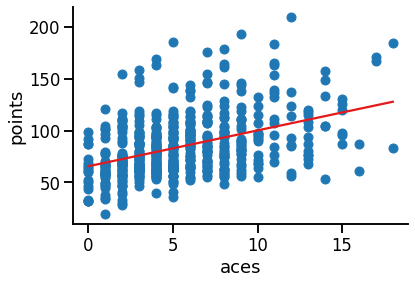

In [13]:
def plot_model(θ, color=red):
    a, b = θ
    yhat = a * x + b
    plt.plot(x, y, 'o')
    plt.plot(x, yhat, '-', color=color)
    plt.xlabel('aces')
    plt.ylabel('points')
    sns.despine()
    print("a={:.3f}, b={:.3f}".format(a, b))
    
plot_model(θ_norm)

The results can be interpreted as follows
- without any aces, Novak wins ~65 points. 
- for any additional ace, he wins an additional ~3.5 point (more than the one point given by the ace)

This model will probably do a good job at *interpolation*, that is estimating $\widehat{y}$ for $x$ values that are within the original $x$ values, but not at *extrapolation*.
For example, if Novak aces all the points in a game, he can't wint 3.5 times the points he aced!

# Poisson model

Since $y$ is positive and discrete, it is somewhat unnatural to model it with a Normal distribution.

A good alternative is to use a Poisson distribution.

$$
y \sim \mathit{Poi}(\widehat{y})
$$

However, since here technically $\widehat{y} \in \mathbb{R}$, this model is misspecified, because the parameter of a Poisson distribution must be positive. We can fix that by having the linear model attempt to estimate the _log_ of the expected value $\widehat{y}$:

$$
\log\widehat{y} = a x + b \\
y \sim \mathit{Poi}(\widehat{y})
$$

Therefore, $\widehat{y} = e^{ax + b} > 0$ and the Poisson parameter is positive.
The log function that links the linear estimator to the model parameter is called the _link function_.

## Exercise: Poisson loss function

Let's try it. The loss function is again defined by the negative log-likelihood, which is defined by the probability mass function of the Poisson distirbution.

Implement the loss function and run the optimization with `fmin`.

In [14]:
from scipy.special import factorial

In [15]:
def poisson_loss(θ, x, y):
    # your code here
    a, b = θ
    log_yhat = (a * x + b)
    log_lik = scipy.stats.poisson.logpmf(y, np.exp(log_yhat)) # logP(k=y | λ=yhat)
    return -log_lik.sum()

In [16]:
θ_poi = scipy.optimize.fmin(
    poisson_loss, # loss function to minimize
    (1, 0), # guess
    args=(x, y) # arguments to loss function
)
print("a={}, b={}".format(*θ_poi))

Optimization terminated successfully.
         Current function value: 3869.107790
         Iterations: 126
         Function evaluations: 244
a=0.038574392536598376, b=4.215991275758418


In [17]:
θ_poi = scipy.optimize.fmin(
    poisson_loss, # loss function to minimize
    (1, 0), # guess
    args=(x, y) # arguments to loss function
)
print("a={}, b={}".format(*θ_poi))

Optimization terminated successfully.
         Current function value: 3869.107790
         Iterations: 126
         Function evaluations: 244
a=0.038574392536598376, b=4.215991275758418


The coefficients are on a different scale because when using the Poisson distribution we assumed that $\log(y) = ax + b$ rather than $y=ax+b$ (here the $\log$ function is the *link function*).

Normal model:
a=3.462, b=65.552
Poisson model:
a=1.039, b=67.761


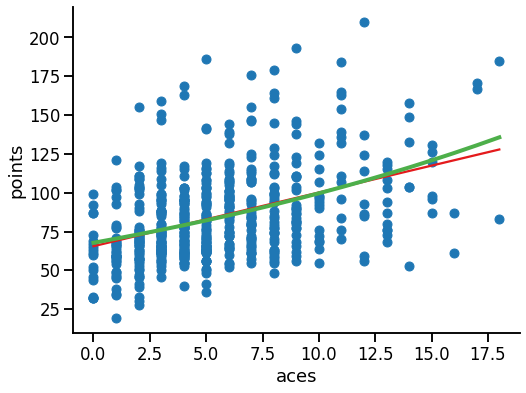

In [18]:
plt.figure(figsize=(8, 6))
print("Normal model:")
plot_model(θ_norm)
print("Poisson model:")
a, b = θ_poi
yhat = np.exp(a * x + b)
plt.plot(x, yhat, '-', lw=4, color=green, label='Poisson')
print("a={:.3f}, b={:.3f}".format(np.exp(a), np.exp(b)))


The plots are very similar for the majority of the range, so the normal model was probably pretty good as a predictive model, but not so much as descriptive model.
Moreover, at the ends of the range (<2.5 aces, >12.5 aces) the Poisson model will probably over-estimate.

Note that the interpretation of $a$ differs between the models: in the linear model there is no link function, so $a$ is the _additive_ change in points per ace. 
In the Poisson model the link function is an exponent, so $a$ is the _multiplicative_ change in points per ace.

# GLM: Generalized linear models

Generalized linear models is the general framework we have just used:

$$
f(\widehat{y}) = a x + b \\
y \sim P(\widehat{y}, \ldots)
$$

where $f$ is a link function that links the linear estimator to the distribution parameters, and $P$ is a distribution that takes as parameters the expected observation $\widehat{y}$, and may also take some additional parameters.

# Off-the-shelf solutions

Let's see how we could have done this with Python's packages instead of reinventing the wheel.

We'll work with NumPy and SciPy, the numerical and scientific backbone of scientific Python.

## NumPy

First method is NumPy's `polyfit` which fits a polynomial of specified degree to the data; in this case we want degree one. It returns the coefficients of the polynomial, which we could feed to `np.poly1d` to create a callable polynomial object.

In [19]:
θ_np = np.polyfit(x, y, 1)
print(*θ_np)

3.4615296227204406 65.55157969668231


Note how much faster NumPy does it.
This is because under-the-hood NumPy calls native code (C/Fortran).
The main drain of calculation time is probably the `while` loop in `linear_model` as each iteration performs redundent type check etc.

In [20]:
%timeit -n 1 -r 1 linear_model(x, y, verbose=False)
%timeit np.polyfit(x, y, 1)

217 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
147 µs ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## SciPy
Next is SciPy's statistics package with its linear regression method, which basically uses the same method `polyfit` does (i.e. exact same result) but then also calculates some statistics.

In [21]:
res = scipy.stats.linregress(x, y)
print(res.slope, res.intercept)

3.4615296227204415 65.55157969668234


The P-value gives the probability to get this data if the null hypothesis is right; in this case, the null hypothesis is $a=0$.

The r-value is the [coefficient of correlation](https://en.wikipedia.org/wiki/Correlation_coefficient).

In [22]:
print('r={}, P={}'.format(res.rvalue, res.pvalue))

r=0.4235692130211396, P=5.278630457817231e-26


# Statsmodels

This package focuses on statistical modeling, and as such, provides a full statistical analysis of the linear model:

$$
\widehat{y} = a x + b \\
y \sim N(\widehat{y}, \sigma^2)
$$

Note that here `y` comes before `x`.

In [23]:
import statsmodels.api as sm

In [24]:
X = sm.add_constant(x) # for intercept
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     123.1
Date:                Tue, 19 May 2020   Prob (F-statistic):           5.28e-26
Time:                        22:30:32   Log-Likelihood:                -2641.6
No. Observations:                 565   AIC:                             5287.
Df Residuals:                     563   BIC:                             5296.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.5516      2.018     32.482      0.000      61.588      69.516
x1             3.4615      0.312     11.095      0.000       2.849       4.074
==============================================================================
Omnibus:                       91.406   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.959
Skew:                           0.993   Prob(JB):                     6.10e-34
Kurtosis:                       4.597   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With `statsmodels` it is easy to use generalized linear models (GLM) to change the probability distribution.

In [25]:
poi_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()
poi_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  565
Model:                            GLM   Df Residuals:                      563
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3869.1
Date:                Tue, 19 May 2020   Deviance:                       4223.3
Time:                        22:30:37   Pearson chi2:                 4.43e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2160      0.009    489.118      0.000       4.199       4.233
x1             0.0386      0.001     31.381      0.000       0.036       0.041
==============================================================================
"""

Of course there are many more twists to add, such as regularization, outlier detection, and linking functions - we'll do the latter in the next session when we deal with the classical classification method, *logistic regression*.

# Bayesian linear models

To perform Bayesian inference with linear models, we just need to decide on a prior distribution for the model parameters $a$ and $b$, and run the MCMC sampler.

$$
\hat{y} = a x_i + b
\\
y \sim N(\hat{y}, \sigma^2) 
$$
with the prior distributions:
$$
a \sim N(1, 4)
\\
b \sim \mathit{Exp}(65)
\\ 
\sigma \sim \mathit{Exp}(10)
$$

I use an exponential prior for parameters that I want to keep positive.

In [26]:
a_prior = scipy.stats.norm(1, 4)
# ended up using trucated normal cause it gave better results
b_prior = scipy.stats.truncnorm(-3, 3, loc=60, scale=20) # mean 60, std 20, truncated between 0 and 120
σ_prior = scipy.stats.expon(10)

def log_prior(θ):
    a, b, σ = θ
    return a_prior.logpdf(a) + b_prior.logpdf(b) + σ_prior.logpdf(σ)

def log_likelihood(θ, x, y):
    a, b, σ = θ
    yhat = a * x + b
    return scipy.stats.norm(yhat, σ).logpdf(y).sum()

def log_posterior(θ, x, y):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y)

In [27]:
ndim = 3
nwalkers = 50
nsteps  = 200
nburn = nsteps // 2
var_names = ['a', 'b', 'σ']

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] = a_prior.rvs(nwalkers)
guesses[:, 1] = b_prior.rvs(nwalkers)
guesses[:, 2] = σ_prior.rvs(nwalkers)

In [29]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y])
sampler.run_mcmc(guesses, nsteps);

We plot a trace plot:

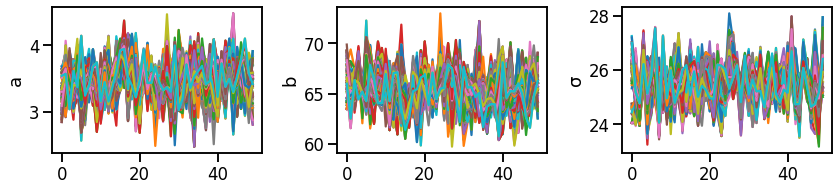

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, param in enumerate(['a', 'b', 'σ']):
    axes[i].plot(sampler.chain[:, nburn:, i])
    axes[i].set_ylabel(param)
fig.tight_layout()

In [31]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
θ_bayes = samples.mean(axis=0)
print("Normal: a={:.3f}, b={:.3f}".format(*θ_norm))
print("Bayes:  a={:.3f}, b={:.3f}, σ={:.3f}".format(*θ_bayes))

Normal: a=3.462, b=65.552
Bayes:  a=3.468, b=65.521, σ=25.456


We plot the posteriors with `corner`:

In [32]:
from corner import corner

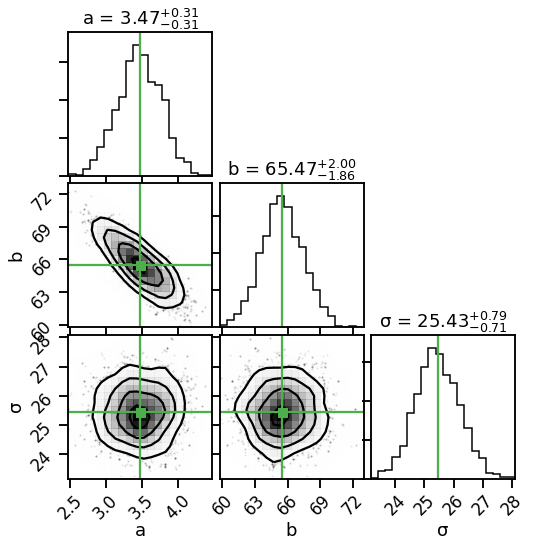

In [33]:
# posterior distributions
corner(
    samples, 
    smooth=True, 
    labels=var_names, 
    show_titles=True, 
    truths=θ_bayes, 
    truth_color=green
);

One advantage of sampling from the poterior is that we can use these samples to plot a posterior prediction plot.

Here, we plot the MAP estimate in red, but also add lines for all the parameters we sampled from the posterior, to demonstrate the dispersion of prediction lines.

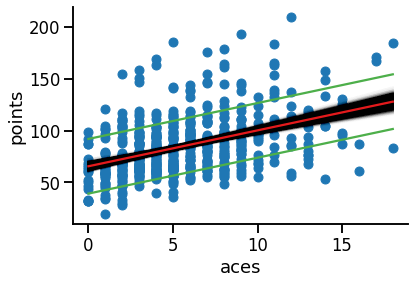

In [34]:
# plot of posterior lines
plt.plot(x, y, 'o')
for θi in samples:
    ai, bi, σ = θi
    yhat = ai * x + bi
    plt.plot(x, yhat, '-k', alpha=0.01)
    
a, b = θ_bayes[:2]
yhat = a * x + b
plt.plot(x, yhat, color=red)

# we expect 66% of the data to fall between the green lines
plt.plot(x, yhat+σ, color=green)
plt.plot(x, yhat-σ, color=green)


plt.xlabel('aces')
plt.ylabel('points')
sns.despine()

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.
- Allen B. Downey, 2014. [Think Stats: Probability and Statistics for Programmers.](http://www.greenteapress.com/thinkstats2/index.html) (Available for free online).
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (the Tennis data is borrowed from there).
- Illustrate distributions using the [Seeing Theory](http://students.brown.edu/seeing-theory/probability-distributions/index.html#section2) webpage.
- Explore how regression is affected by outliers using the [Seeing Theory](http://students.brown.edu/seeing-theory/regression-analysis/index.html#section1) webpage.
- Jake VanDerPlas's series of [blog posts on Bayesian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- [emcee](https://emcee.readthedocs.io/): the MCMC Hammer
- [corner](http://corner.readthedocs.io/): joint plots

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)